In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

import sys
sys.path.append("../src")

from data_prep import *
from make_cuts import *
from fitting_functions import *
from pulse_profile_generator import *
from plot_maker import *
from pulse_plot_maker import *

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
ci_folder="../../data/calibration/charge_injections/"
c_folder="../../data/calibration/"
Path("../../plots").mkdir(parents=True, exist_ok=True)
Path("../../plots/charge_injections").mkdir(parents=True, exist_ok=True)
p_folder="../../plots/charge_injections/"

In [4]:
charge_injection_runs=["scan_DPM0_CALIBRUN_coff14_20220419_073825.csv",
                       "scan_DPM0_CALIBRUN_coff14_20220424_071302.csv",
                       "scan_DPM0_CALIBRUN_coff14_20220424_220633.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220419_081316.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220424_071550.csv",
                       "scan_DPM1_CALIBRUN_coff14_20220424_220543.csv"]

In [24]:
linkmap=pd.read_csv(c_folder+"map.csv")
pedestal_df=pd.read_csv(c_folder+"pedestal.csv", sep=',') # normal pedestal_file needs to be used

In [76]:
# ALL prep
c0=pd.read_csv(ci_folder+charge_injection_runs[1])
merged0=c0.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged0.drop(["DPM", "ILINK", "CHAN", "SIPM_BIAS", "LINK"], axis=1, inplace=True)
merged0.drop(list(merged0.filter(regex = 'TOA.?')), axis=1, inplace=True)

pmerged=merged0.merge(pedestal_df, how="left", left_on=["PLANE", "STRIP", "END"], right_on=["layer", "strip", "end"])

for i in range(8):  # believe it or not, the loop is faster than a wildcard lookup
    adc_col = f'ADC{i}'
    pmerged[adc_col]-=pmerged["pedestal_per_time_sample"]

pmerged.drop(["PLANE", "STRIP", "END", "pedestal", "mean", "std_dev",
              "pedestal_per_time_sample", "pedestal_per_time_sample_mean", "pedestal_per_time_sample_std_dev"], axis=1, inplace=True)

In [77]:
ADC_max=pmerged[list(pmerged.filter(regex = 'ADC.?'))].max(axis=1)
pmerged=pmerged.assign(adc_max=ADC_max)
pmerged.drop(list(pmerged.filter(regex = 'ADC.?')), axis=1, inplace=True)

TOT_max=pmerged[list(pmerged.filter(regex = 'TOT.?'))].max(axis=1)
pmerged=pmerged.assign(tot_max=TOT_max)
pmerged.drop(list(pmerged.filter(regex = 'TOT.?')), axis=1, inplace=True)

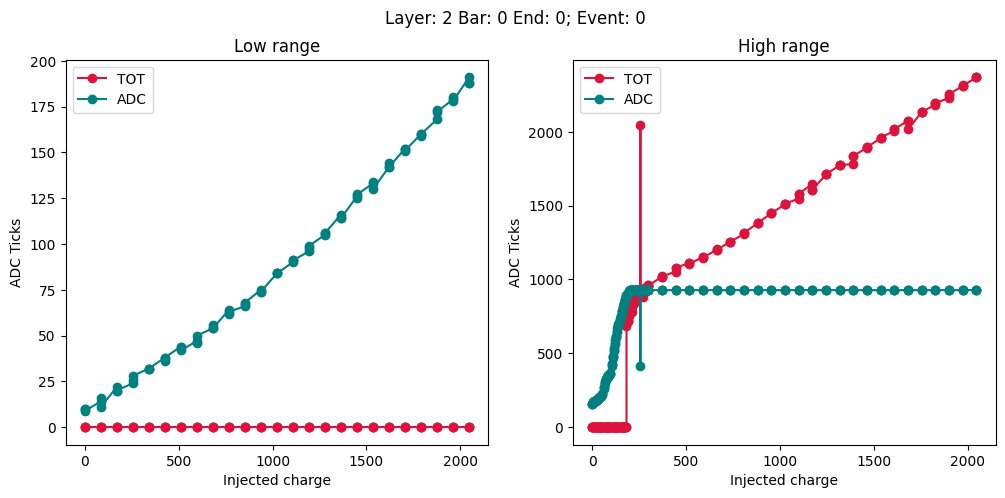

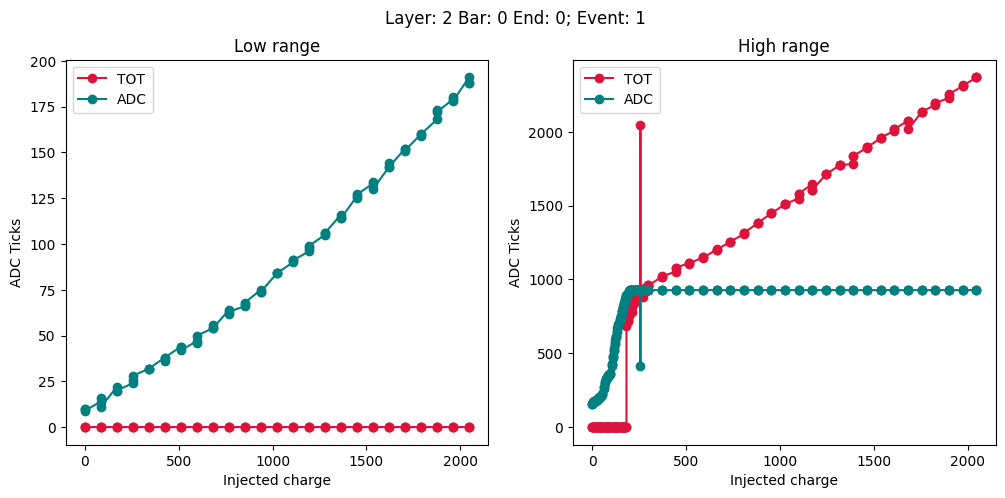

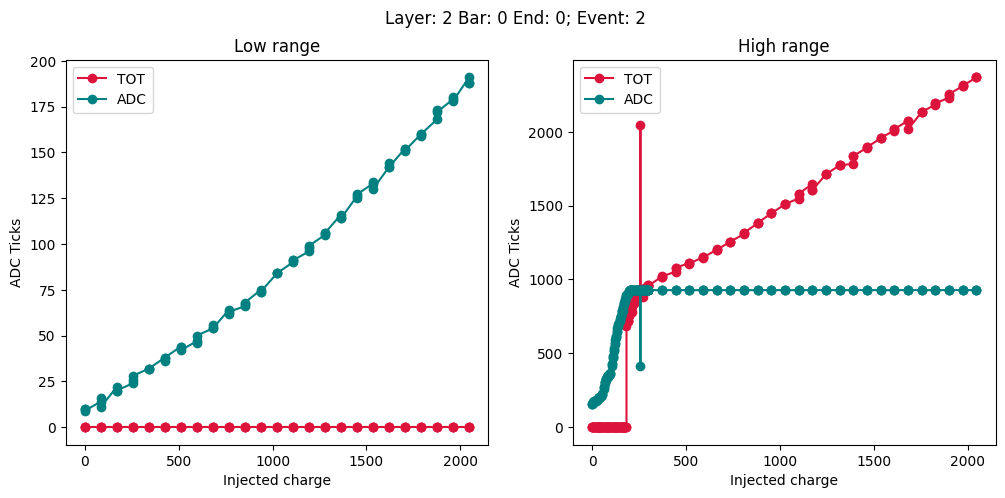

In [100]:
plt.rcParams["figure.figsize"]=(12,5)
for event in [0,1,2]:
    for layer in np.sort(pmerged.layer.unique())[1:2]:
        for bar in np.sort(pmerged[pmerged["layer"]==layer].strip.unique())[:1]:
            for end in [0]:
                single_channel=pmerged[(pmerged["layer"]==layer) & (pmerged["strip"]==bar) & (pmerged["end"]==end)]
                low_range=single_channel[single_channel["CAPACITOR_TYPE"]==0]
                high_range=single_channel[single_channel["CAPACITOR_TYPE"]==1]
                
                plt.suptitle("Layer: "+str(layer)+" Bar: "+str(bar)+" End: "+str(end)+"; Event: "+str(event))
                plt.subplot(1,2,1)
                plt.plot(low_range["CALIB_DAC"],low_range["tot_max"], label="TOT", color="crimson", marker='o')
                plt.plot(low_range["CALIB_DAC"],low_range["adc_max"], label="ADC", color="teal", marker='o')
                plt.ylabel("ADC Ticks")
                plt.xlabel("Injected charge")
                plt.title("Low range")
                plt.legend()
                
                plt.subplot(1,2,2)
                plt.plot(high_range["CALIB_DAC"],high_range["tot_max"], label="TOT", color="crimson", marker='o')
                plt.plot(high_range["CALIB_DAC"],high_range["adc_max"], label="ADC", color="teal", marker='o')
                plt.ylabel("ADC Ticks")
                plt.xlabel("Injected charge")
                plt.title("High range")
                plt.legend()
                plt.show()

In [6]:
c0=pd.read_csv(ci_folder+charge_injection_runs[0])
c1=pd.read_csv(ci_folder+charge_injection_runs[1])
c2=pd.read_csv(ci_folder+charge_injection_runs[2])
c3=pd.read_csv(ci_folder+charge_injection_runs[3])
c4=pd.read_csv(ci_folder+charge_injection_runs[4])
c5=pd.read_csv(ci_folder+charge_injection_runs[5])

In [198]:
merged0=c0.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged1=c1.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged2=c2.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged3=c3.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged4=c4.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])
merged5=c5.merge(linkmap, how="inner", left_on=["CHAN", "DPM", "ILINK"], right_on=["CHAN", "DPM", "LINK"])


merged0.drop(["DPM", "ILINK", "CHAN", "SIPM_BIAS", "LINK"], axis=1, inplace=True)

In [126]:
single_channel=merged0[(merged0["PLANE"]==1) & (merged0["STRIP"]==0) & (merged0["END"]==0)]

In [192]:
single_channel=merged5[(merged5["PLANE"]==16) & (merged5["STRIP"]==9) & (merged5["END"]==0)]

In [193]:
event=0

single_event=single_channel[single_channel["EVENT"]==event]

ADC_max=single_event[list(single_event.filter(regex = 'ADC.?'))].max(axis=1)
single_event=single_event.assign(ADC_MAX=ADC_max)

TOT_max=single_event[list(single_event.filter(regex = 'TOT.?'))].max(axis=1)
single_event=single_event.assign(TOT_MAX=TOT_max)

In [194]:
cap_1=single_event[single_event["CAPACITOR_TYPE"]==1]
cap_0=single_event[single_event["CAPACITOR_TYPE"]==0]

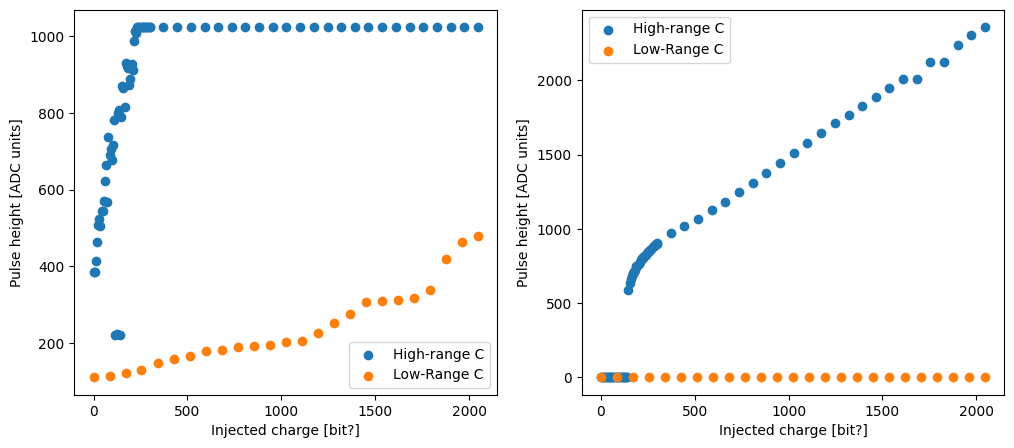

In [195]:
plt.rcParams["figure.figsize"]=(12,5)
plt.subplot(1,2,1)
plt.scatter(cap_1["CALIB_DAC"],cap_1["ADC_MAX"], label="High-range C")
plt.scatter(cap_0["CALIB_DAC"],cap_0["ADC_MAX"], label="Low-Range C")
plt.ylabel("Pulse height [ADC units]")
plt.xlabel("Injected charge [bit?]")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(cap_1["CALIB_DAC"],cap_1["TOT_MAX"], label="High-range C")
plt.scatter(cap_0["CALIB_DAC"],cap_0["TOT_MAX"], label="Low-Range C")
plt.ylabel("Pulse height [ADC units]")
plt.xlabel("Injected charge [bit?]")
plt.legend()
plt.show()

In [141]:
single_channel=merged3[(merged3["PLANE"]==16) & (merged3["STRIP"]==9) & (merged3["END"]==0)]

In [150]:
adcs=single_channel[list(single_channel.filter(regex = 'ADC.?'))]

In [153]:
adcs

,ADC0,ADC1,ADC2,ADC3,ADC4,ADC5,ADC6,ADC7
309,89,95,97,105,97,101,97,95
315,95,95,99,105,117,113,97,127
321,95,127,103,109,109,103,49,48
885,93,93,101,111,97,113,49,63
891,95,95,103,119,119,103,51,47
...,...,...,...,...,...,...,...,...
56763,93,95,936,511,511,511,511,17
56769,95,95,464,511,1023,511,511,936
57333,95,95,940,511,1023,1023,1023,511
57339,127,113,439,1023,1023,1023,511,511


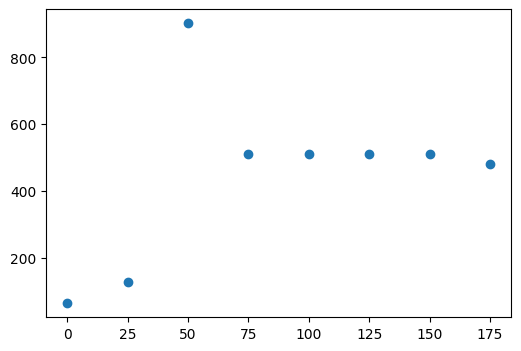

In [157]:
i=57345
plt.rcParams["figure.figsize"]=(6,4)
plt.scatter(np.arange(0,200,25), adcs.loc[i])